In [2]:
import pandas as pd
import numpy as np
import yaml
import os
from pathlib import Path


def load_file(path):
  with open(path, "r") as f:
    return yaml.load(f, Loader=yaml.FullLoader)
  
dir_files = os.path.join(os.path.dirname("__file__"), "results")
files = os.listdir(dir_files)
sols = [load_file(Path(dir_files,  f)) for f in files if f.endswith("_sol.yml")]


In [16]:
from itertools import chain
import jmespath

obj_path = jmespath.compile("solution.obj")

rows = []
for e in chain.from_iterable(sols):
    rows.append({
        "configuration": e.get("configuration"),
        "model": e.get("model"),
        "obj": obj_path.search(e),
        "time": e.get("time"),
    })

df_sols = pd.DataFrame(rows)
df_sols

,configuration,model,obj,time
0,Atlantis_BB,models/model/windfarm01.mzn,NaN,NaN
1,Atlantis_BB,models/model/windfarm02.mzn,NaN,NaN
2,Gecode_BB,models/model/windfarm01.mzn,245451631.0,43.827
3,Gecode_BB,models/model/windfarm01.mzn,245453189.0,43.932
4,Gecode_BB,models/model/windfarm01.mzn,246105023.0,44.036
...,...,...,...,...
175,Gecode_BB,models/model/windfarm02.mzn,252875342.0,810.110
176,Gecode_BB,models/model/windfarm02.mzn,252875413.0,810.193
177,Gecode_BB,models/model/windfarm02.mzn,252876208.0,835.586
178,Gecode_BB,models/model/windfarm02.mzn,252877000.0,860.776


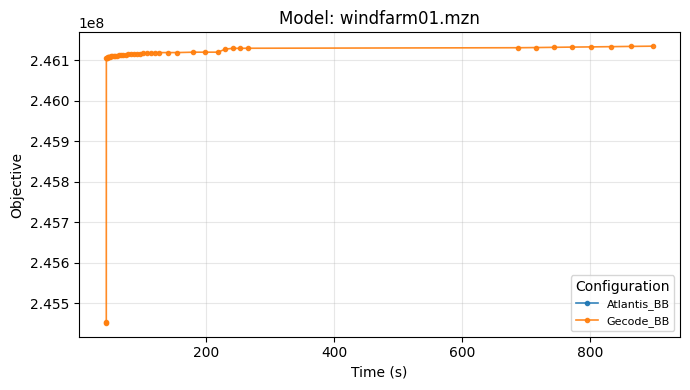

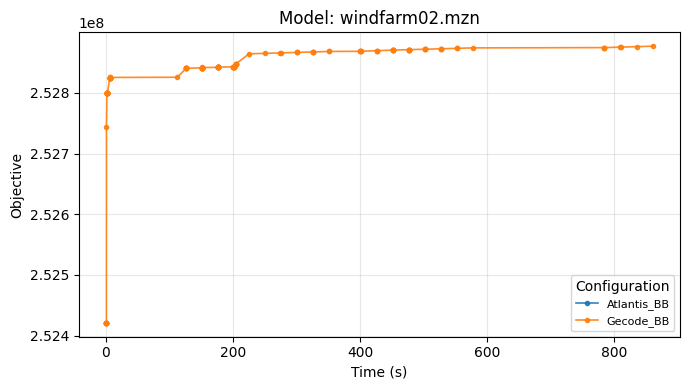

In [17]:
import matplotlib.pyplot as plt

# Plot obj vs time for each model, comparing configurations
for model_name, dfm in df_sols.groupby("model"):
    fig, ax = plt.subplots(figsize=(7, 4))
    for cfg, dfg in dfm.groupby("configuration"):
        dfg = dfg.sort_values("time")
        ax.plot(dfg.time, dfg.obj, marker="o", ms=3, linewidth=1.2, label=cfg, alpha=0.9)
    ax.set_title(f"Model: {Path(model_name).name}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Objective")
    ax.legend(title="Configuration", fontsize=8)
    ax.grid(alpha=0.3)
    plt.tight_layout()

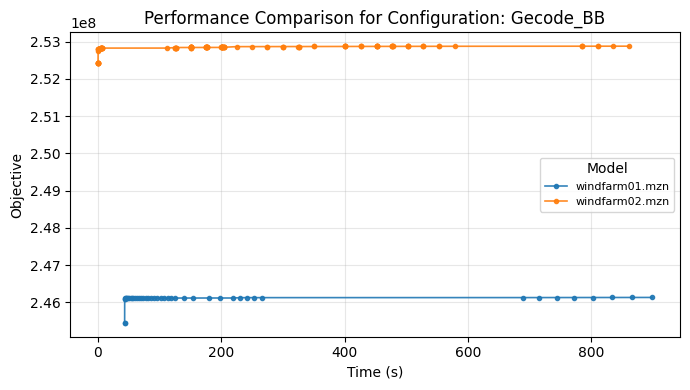

In [18]:
# Filter dataframe for the desired configuration
cfg = "Gecode_BB"
df_cfg = df_sols[df_sols["configuration"] == cfg]

# Plot obj vs time for each model under the same configuration
fig, ax = plt.subplots(figsize=(7, 4))
for model, dfm in df_cfg.groupby("model"):
    dfm = dfm.sort_values("time")
    ax.plot(dfm.time, dfm.obj, marker="o", ms=3, linewidth=1.2, label=Path(model).name, alpha=0.9)
ax.set_title(f"Performance Comparison for Configuration: {cfg}")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Objective")
ax.legend(title="Model", fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()